<a href="https://colab.research.google.com/github/lelough175/Project_phan_loai_du_lieu_anh_sieu_am_tim/blob/main/Project_giua_ki_hoc_may.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thư viện

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


Chuẩn bị dữ liệu

In [13]:
drive.mount("/content/drive")
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"
!unzip -uq "/content/drive/My Drive/vgg16_bn.pth.zip" -d "./"
data_dir = "DATA_CHAMBER_2021"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
TRAIN = 'train'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.Resize((64,64)),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 6717 images under train
Loaded 1607 images under test
Classes: 
['2C', '3C', '4C']


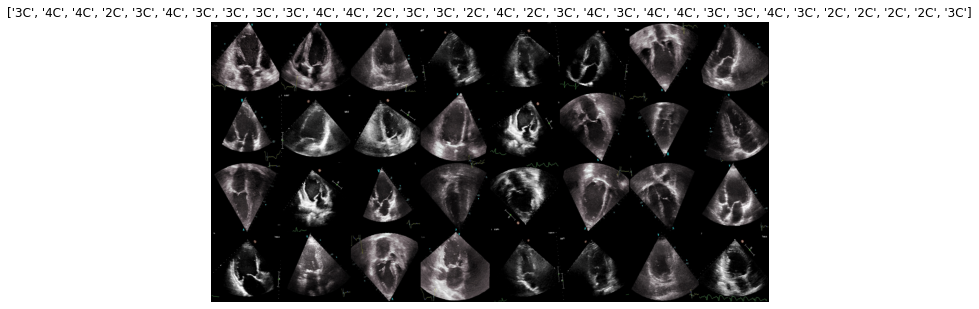

In [15]:
  def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

In [17]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 10 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

Mô hình huấn luyện

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    
    train_batches = len(dataloaders[TRAIN])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        acc_train = 0
        
        model.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            
            # statistics
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train / dataset_sizes[TRAIN]
        
        model.train(False)
        model.eval()
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print()
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

Huấn luyện

Resnet-50


In [19]:
# Tinh chỉnh chuyển đổi
# Load the pretrained model from pytorch
resnet50 = models.resnet50(pretrained=True)

# Freeze training for all layers
for param in resnet50.parameters():
    param.require_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 3)

if use_gpu:
    resnet50.cuda() #.cuda() will move everything to the GPU side

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
# Thực hiện huấn luyện
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)
torch.save(resnet50.state_dict(), 'ResNet_50.pt')

Epoch 0/7
----------
Training batch 200/210

Epoch 0 result: 
Avg loss (train): 0.0165
Avg acc (train): 0.7700

Epoch 1/7
----------
Training batch 200/210

Epoch 1 result: 
Avg loss (train): 0.0027
Avg acc (train): 0.9739

Epoch 2/7
----------
Training batch 200/210

Epoch 2 result: 
Avg loss (train): 0.0010
Avg acc (train): 0.9911

Epoch 3/7
----------
Training batch 200/210

Epoch 3 result: 
Avg loss (train): 0.0006
Avg acc (train): 0.9954

Epoch 4/7
----------
Training batch 200/210

Epoch 4 result: 
Avg loss (train): 0.0004
Avg acc (train): 0.9964

Epoch 5/7
----------
Training batch 200/210

Epoch 5 result: 
Avg loss (train): 0.0004
Avg acc (train): 0.9967

Epoch 6/7
----------
Training batch 200/210

Epoch 6 result: 
Avg loss (train): 0.0003
Avg acc (train): 0.9972


Training completed in 23m 34s
Best acc: 0.9972


VGG-16


In [21]:
# Tinh chỉnh chuyển đổi
vgg16 = models.vgg16_bn(pretrained=True)
print(vgg16.classifier[6].out_features) # 1000 

for param in vgg16.features.parameters():
    param.require_grad = False

num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 3)
print(vgg16.classifier[6].out_features) # 3
#print(vgg16)

if use_gpu:
    vgg16.cuda()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

1000
3


In [22]:
# Thực hiện huấn luyện
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)
torch.save(vgg16.state_dict(), 'VGG_16.pt')

Epoch 0/7
----------
Training batch 200/210

Epoch 0 result: 
Avg loss (train): 0.0173
Avg acc (train): 0.7544

Epoch 1/7
----------
Training batch 200/210

Epoch 1 result: 
Avg loss (train): 0.0033
Avg acc (train): 0.9635

Epoch 2/7
----------
Training batch 200/210

Epoch 2 result: 
Avg loss (train): 0.0015
Avg acc (train): 0.9839

Epoch 3/7
----------
Training batch 200/210

Epoch 3 result: 
Avg loss (train): 0.0007
Avg acc (train): 0.9933

Epoch 4/7
----------
Training batch 200/210

Epoch 4 result: 
Avg loss (train): 0.0006
Avg acc (train): 0.9929

Epoch 5/7
----------
Training batch 200/210

Epoch 5 result: 
Avg loss (train): 0.0004
Avg acc (train): 0.9967

Epoch 6/7
----------
Training batch 200/210

Epoch 6 result: 
Avg loss (train): 0.0004
Avg acc (train): 0.9945


Training completed in 36m 27s
Best acc: 0.9967


Densenet-121

In [23]:
# Densenet-121
densenet = models.densenet121(pretrained=True)
print(densenet.classifier.out_features) # 1000 

for param in densenet.parameters():
    param.require_grad = False

num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 3)
print(densenet.classifier.out_features) # 3

if use_gpu:
    densenet.cuda()

optimizer_ft = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

1000
3


In [28]:
# Thực hiện huấn luyện
densenet = train_model(densenet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)
torch.save(densenet.state_dict(), 'Densenet_121.pt')

Epoch 0/7
----------
Training batch 200/210

Epoch 0 result: 
Avg loss (train): 0.0162
Avg acc (train): 0.7825

Epoch 1/7
----------
Training batch 200/210

Epoch 1 result: 
Avg loss (train): 0.0031
Avg acc (train): 0.9728

Epoch 2/7
----------
Training batch 200/210

Epoch 2 result: 
Avg loss (train): 0.0011
Avg acc (train): 0.9912

Epoch 3/7
----------
Training batch 200/210

Epoch 3 result: 
Avg loss (train): 0.0006
Avg acc (train): 0.9961

Epoch 4/7
----------
Training batch 200/210

Epoch 4 result: 
Avg loss (train): 0.0004
Avg acc (train): 0.9958

Epoch 5/7
----------
Training batch 200/210

Epoch 5 result: 
Avg loss (train): 0.0005
Avg acc (train): 0.9958

Epoch 6/7
----------
Training batch 200/210

Epoch 6 result: 
Avg loss (train): 0.0003
Avg acc (train): 0.9976


Training completed in 25m 3s
Best acc: 0.9976


Đánh giá

Test ResNet-50 after training
Evaluating model
----------
Test batch 50/51
Evaluation completed in 0m 18s
Avg loss (test): 0.0160
Avg acc (test): 0.8656
----------
Ground truth:


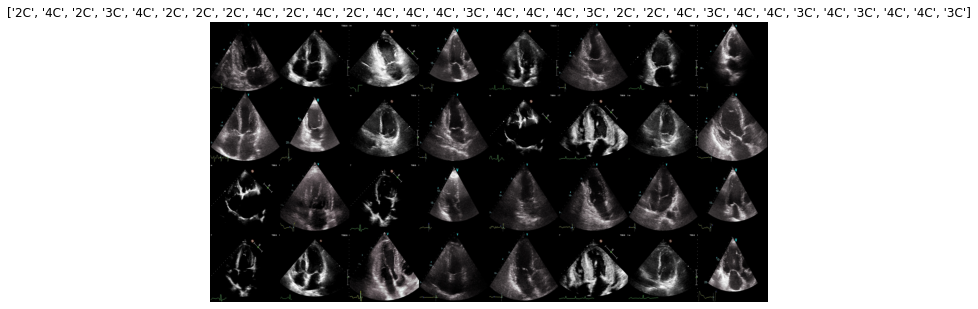

Prediction:


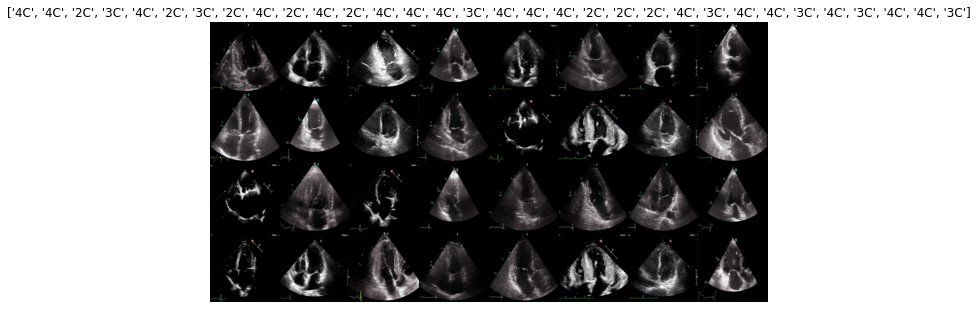

Ground truth:


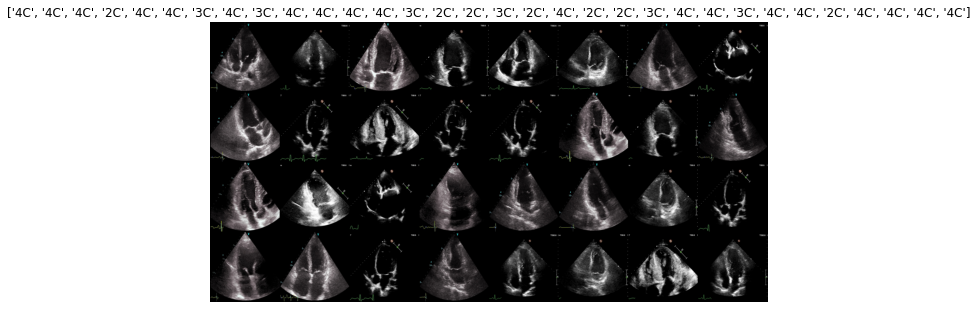

Prediction:


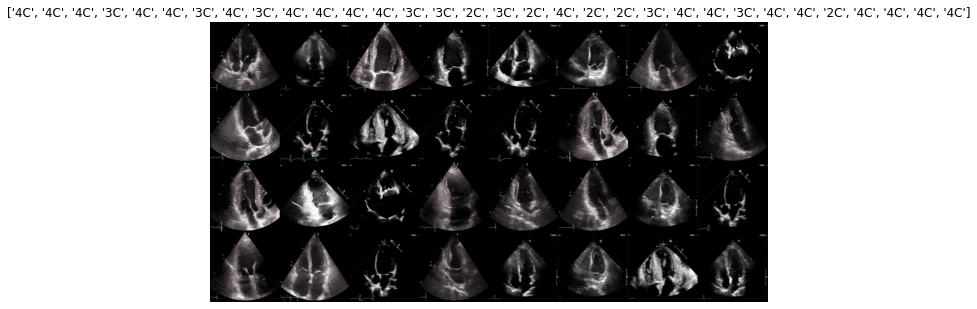

Ground truth:


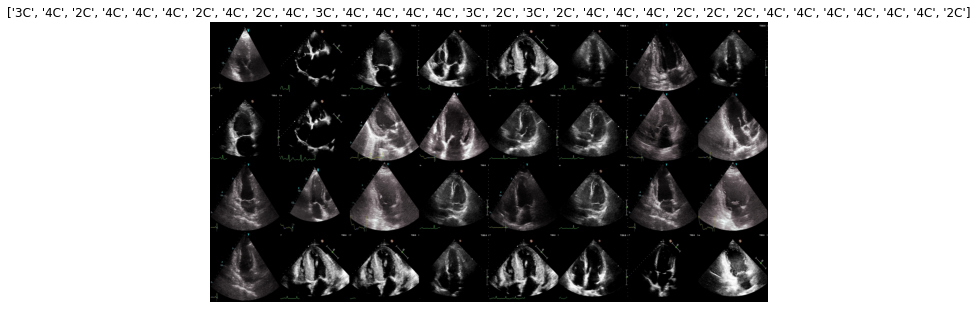

Prediction:


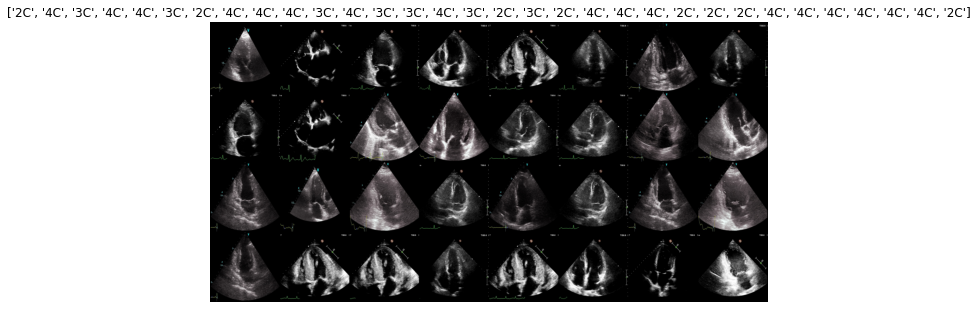

Ground truth:


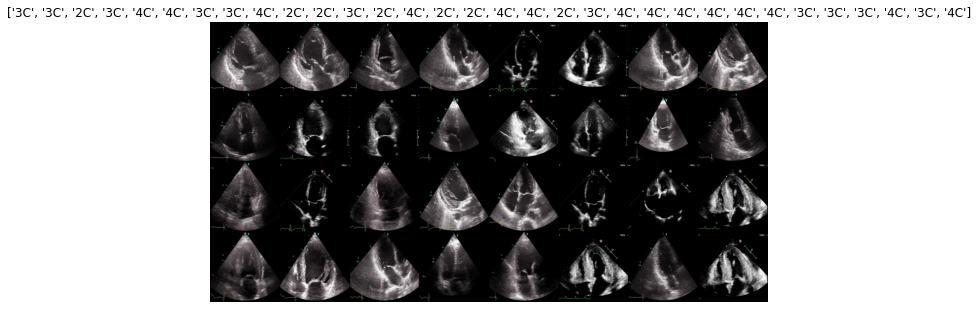

Prediction:


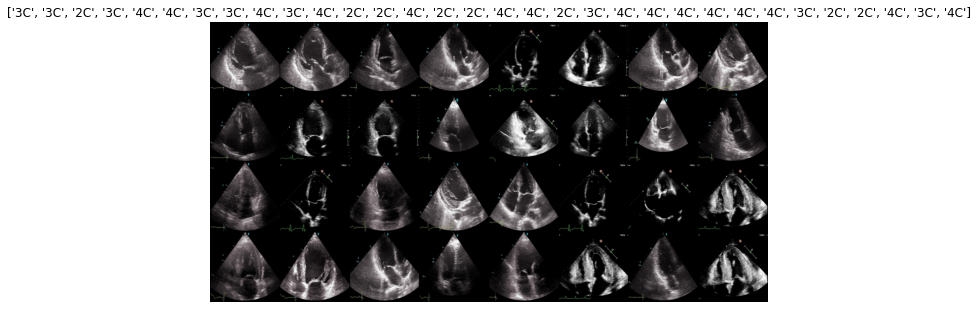

Ground truth:


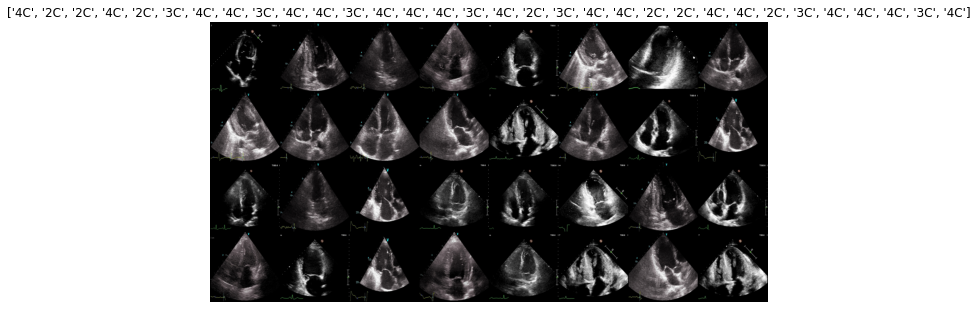

Prediction:


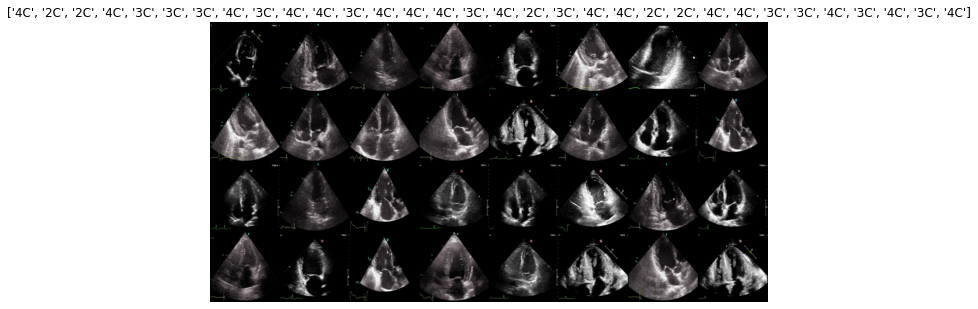

In [29]:
# ResNet-50
print("Test ResNet-50 after training")
eval_model(resnet50, criterion)
visualize_model(resnet50, num_images=32*5)

Test VGG-16 after training
Evaluating model
----------
Test batch 50/51
Evaluation completed in 0m 22s
Avg loss (test): 0.0149
Avg acc (test): 0.8625
----------
Ground truth:


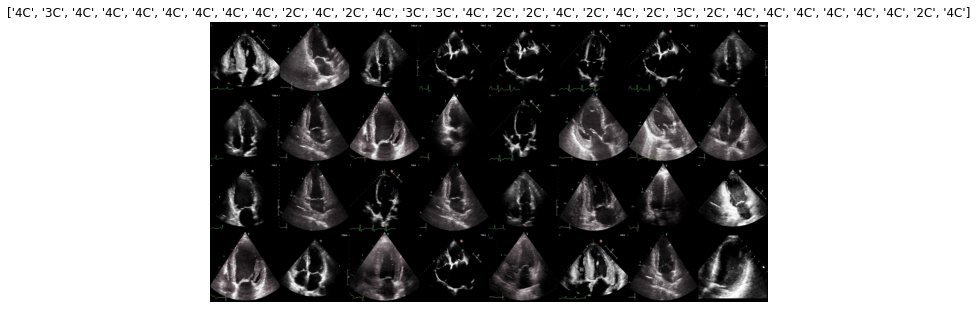

Prediction:


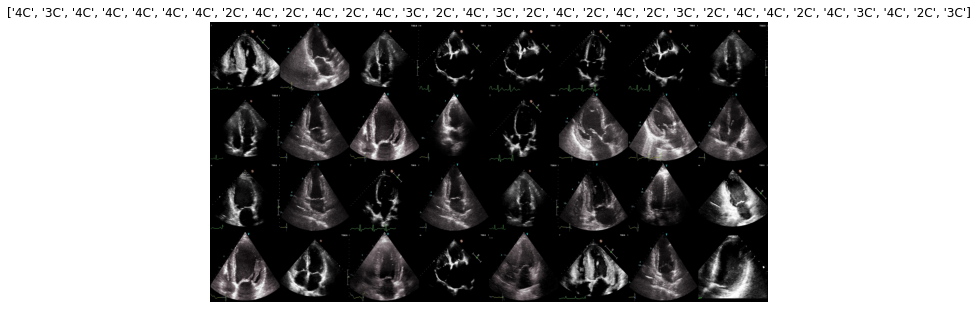

Ground truth:


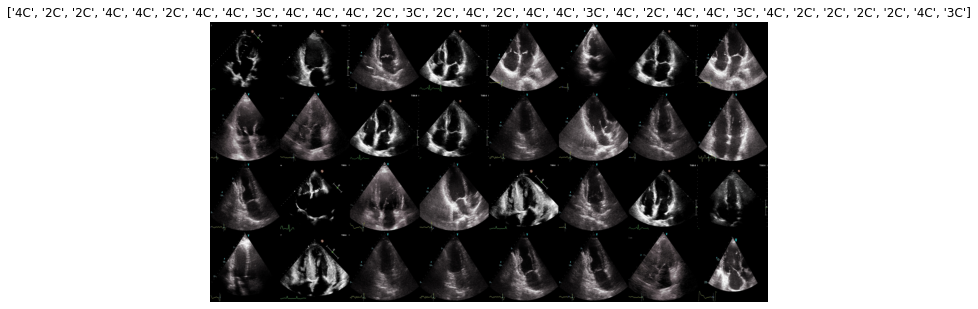

Prediction:


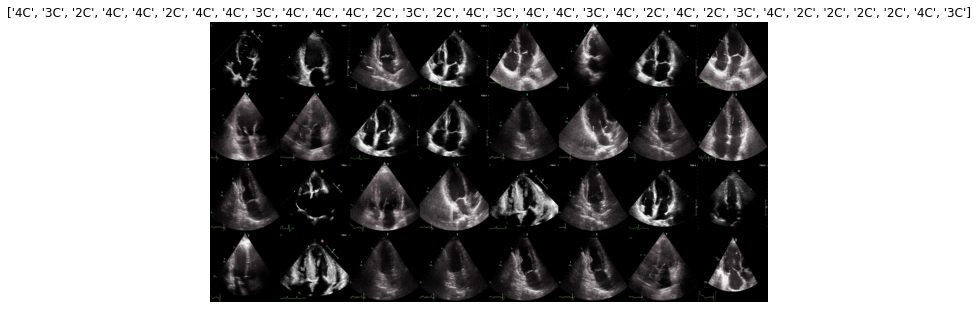

Ground truth:


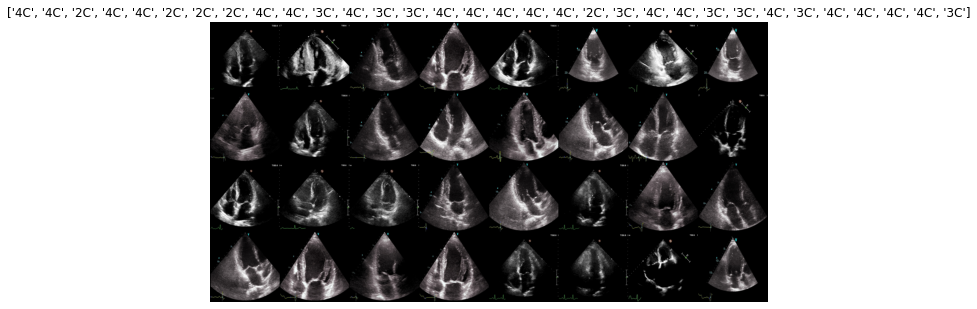

Prediction:


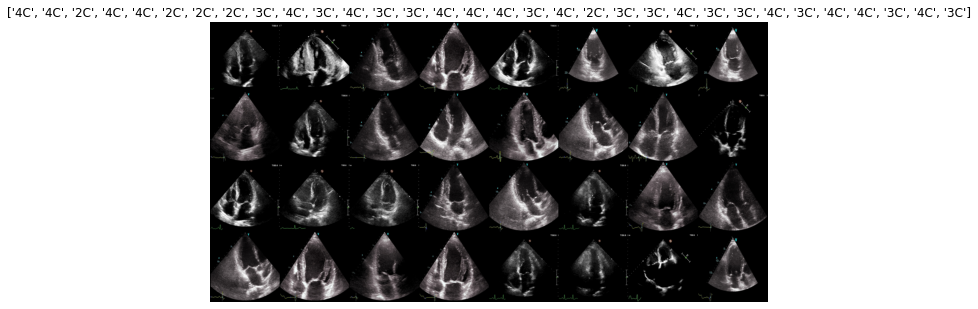

Ground truth:


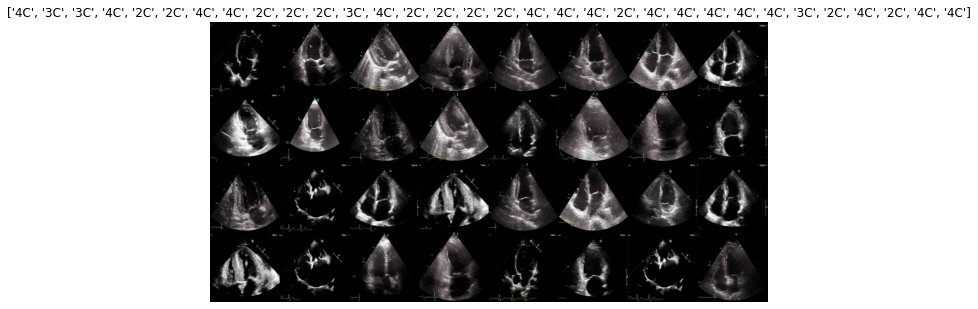

Prediction:


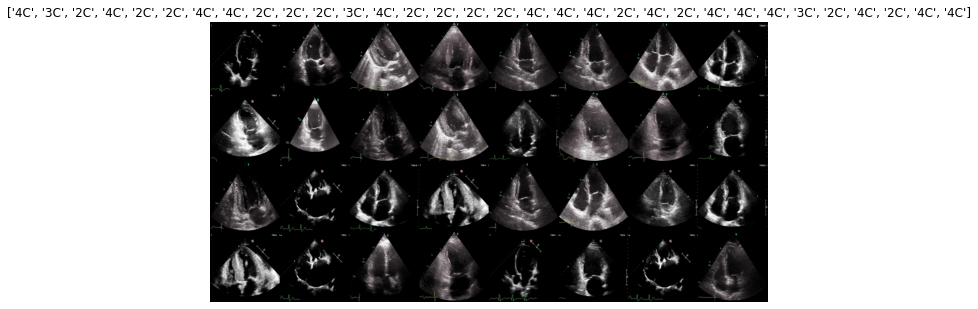

Ground truth:


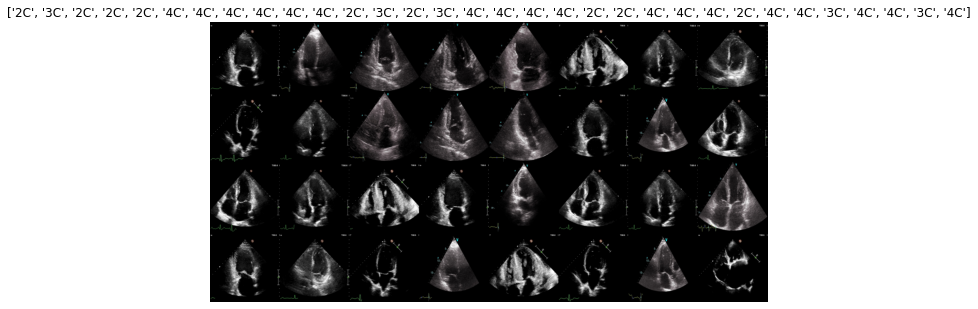

Prediction:


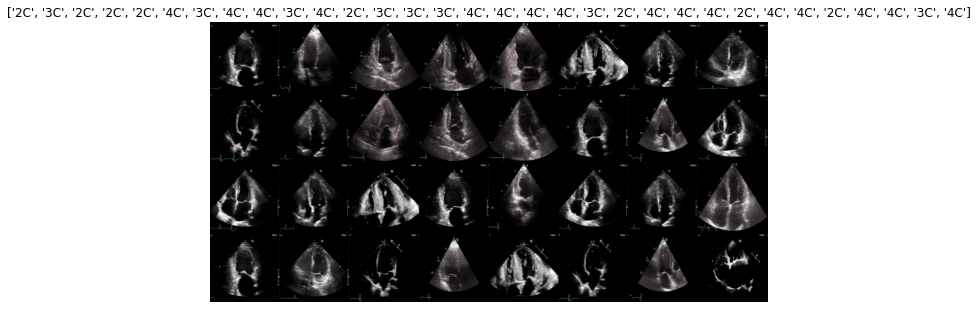

In [30]:
# VGG-16
print("Test VGG-16 after training")
eval_model(vgg16, criterion)
visualize_model(vgg16, num_images=32*5)

Test Densenet-121 after training
Evaluating model
----------
Test batch 50/51
Evaluation completed in 0m 24s
Avg loss (test): 0.0161
Avg acc (test): 0.8681
----------
Ground truth:


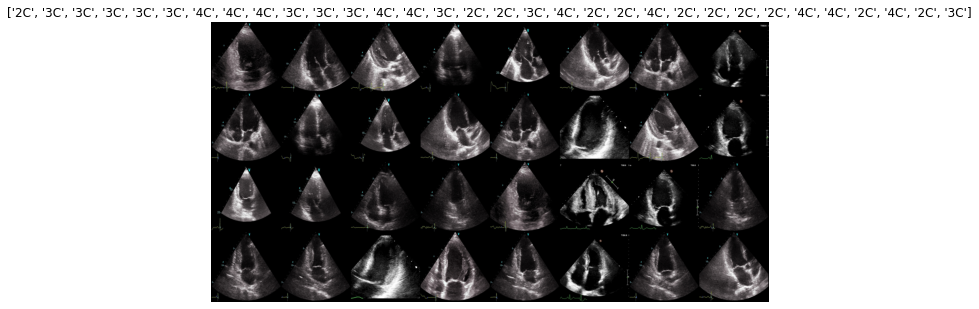

Prediction:


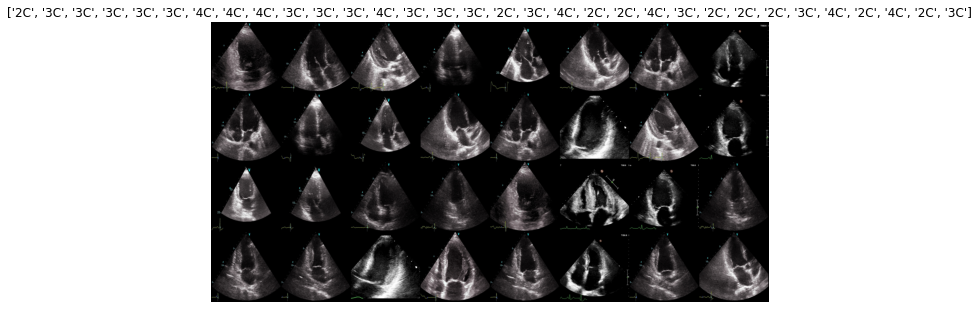

Ground truth:


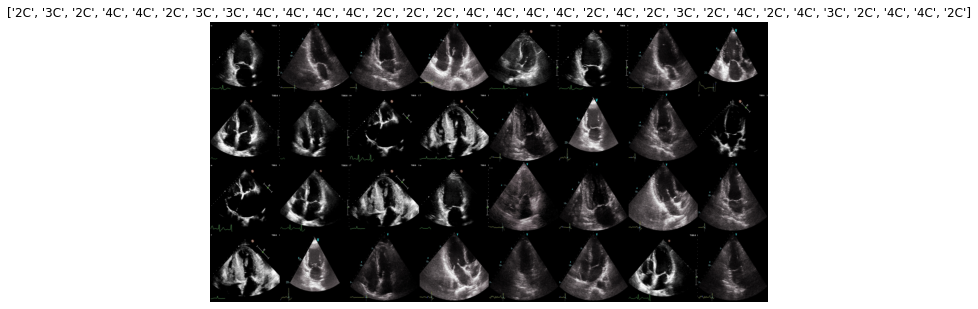

Prediction:


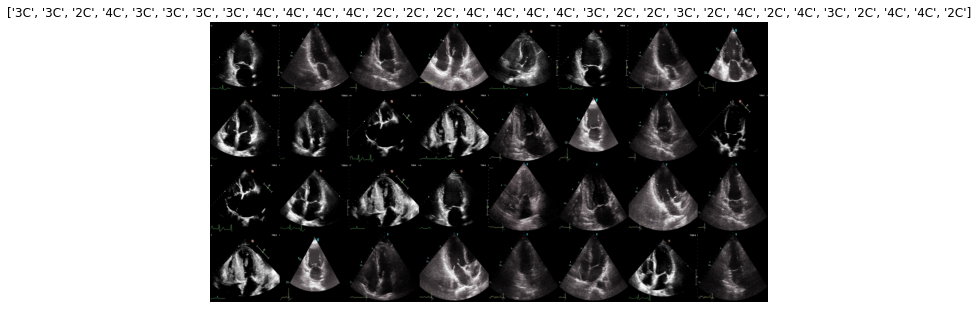

Ground truth:


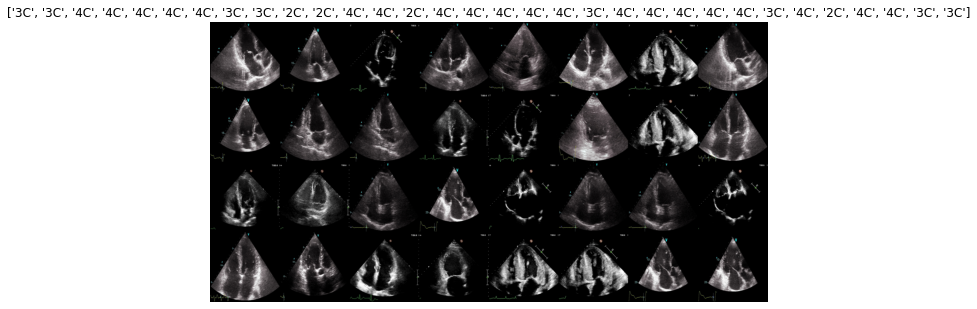

Prediction:


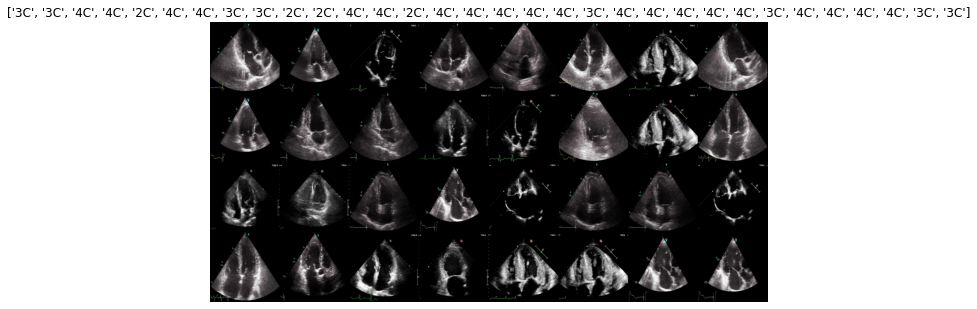

Ground truth:


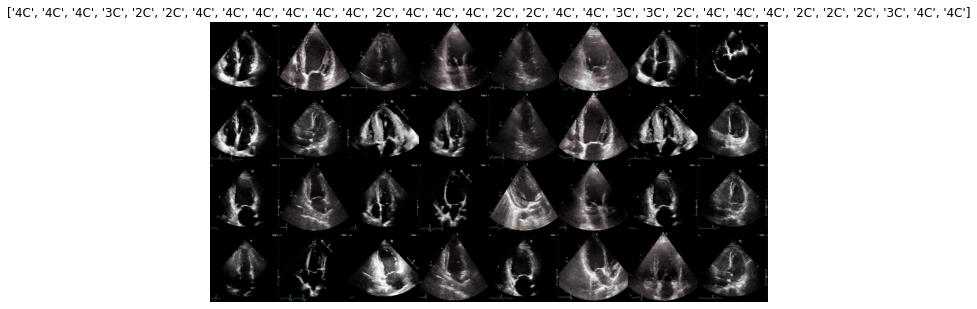

Prediction:


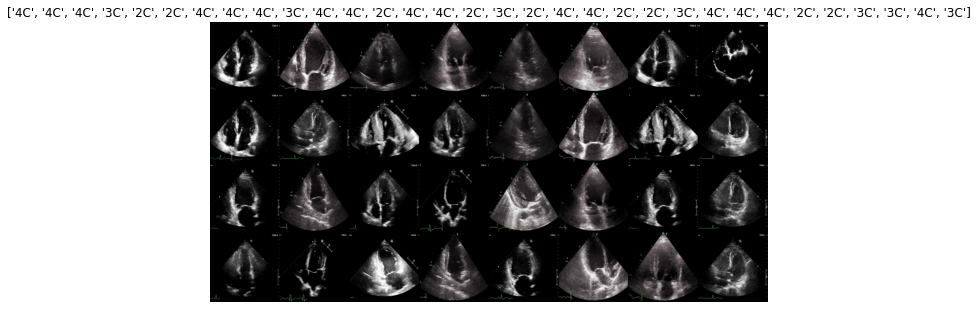

Ground truth:


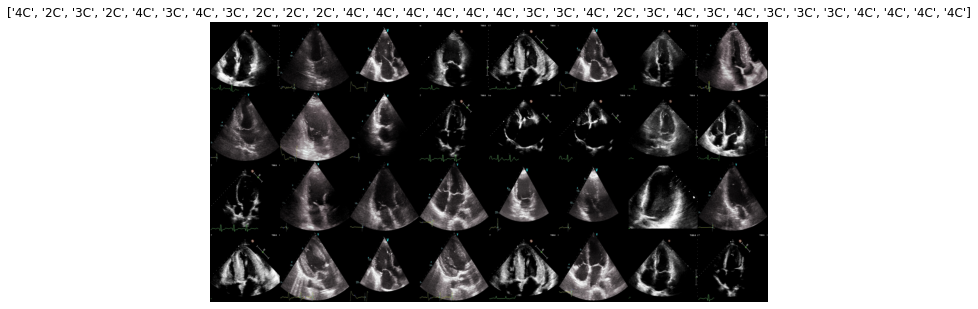

Prediction:


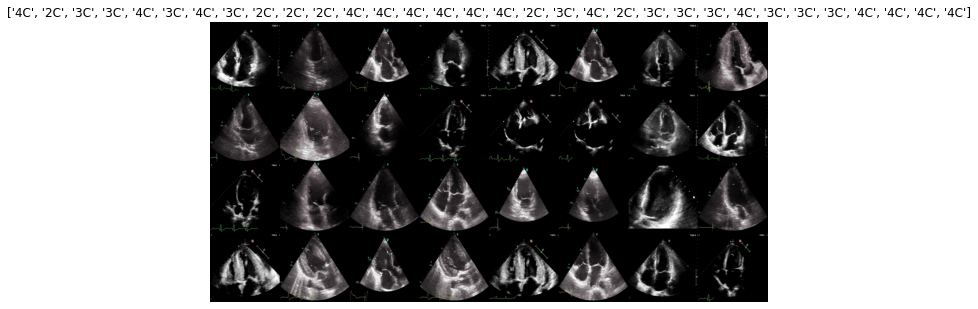

In [31]:
# Densenet-121
print("Test Densenet-121 after training")
eval_model(densenet, criterion)
visualize_model(densenet, num_images=32*5)